# The StateSnapshot Class

### Set the OpenAI API Key

In [1]:
import sys
sys.path.append("..")
import sks_config
%load_ext mypy_ipython

### Import Relevant Classes and Functions

In [2]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage, RemoveMessage
from langgraph.checkpoint.memory import InMemorySaver

### Define the State

In [3]:
class State(MessagesState):
    summary: str

### Define the Nodes

In [4]:
chat = ChatOpenAI(api_key = sks_config.SKS_OPENAI_API_KEY,
                  model = "gpt-4o-mini", 
                  seed = 365, 
                  temperature = 0, 
                  max_completion_tokens = 100)

In [5]:
def ask_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_question:")
    
    question = "What is your question?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [6]:
def chatbot(state: State) -> State:
    
    print(f"\n-------> ENTERING chatbot:")
        
    system_message = f'''
    Here's a quick summary of what's been discussed so far:
    {state.get("summary", "")}
    
    Keep this in mind as you answer the next question.
    '''
    
    response = chat.invoke([SystemMessage(system_message)] + state["messages"])
    response.pretty_print()
    
    return State(messages = [response])

In [7]:
def summarize_messages(state: State) -> State:
    print(f"\n-------> ENTERING summarize_messages:")

    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"
    
    summary_instructions = f'''
Update the ongoing summary by incorporating the new lines of conversation below. 
Build upon the previous summary rather than repeating it, 
so that the result reflects the most recent context and developments.
Respond only with the summary.

Previous Summary:
{state.get("summary", "")}

New Conversation:
{new_conversation}
'''

    print(summary_instructions)

    summary = chat.invoke([HumanMessage(summary_instructions)])
    
    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]]

    return State(messages = remove_messages, summary = summary.content)

### Define the Graph

In [8]:
graph = StateGraph(State)

In [9]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("summarize_messages", summarize_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "summarize_messages")
graph.add_edge("summarize_messages", END)

In [10]:
checkpointer = InMemorySaver()
graph_compiled = graph.compile(checkpointer)

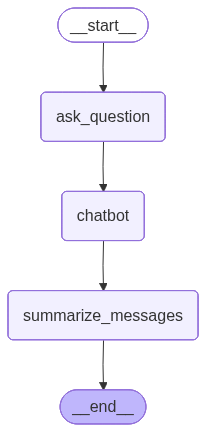

In [11]:
graph_compiled

In [12]:
config1 = {"configurable": {"thread_id": "1"}}
config2 = {"configurable": {"thread_id": "2"}}

In [15]:
graph_compiled.invoke(State(), config2)


-------> ENTERING ask_question:
What is your question?


 Which topic we are talking about?



-------> ENTERING chatbot:
================================== Ai Message ==================================

We are discussing recommended books for individuals involved in AI/ML startups.

-------> ENTERING summarize_messages:

Update the ongoing summary by incorporating the new lines of conversation below. 
Build upon the previous summary rather than repeating it, 
so that the result reflects the most recent context and developments.
Respond only with the summary.

Previous Summary:
In the ongoing conversation, the human inquired about the best books for someone involved in AI/ML startups. The AI responded with a list of highly recommended titles, including **"Deep Learning" by Ian Goodfellow, Yoshua Bengio, and Aaron Courville**, which serves as a comprehensive resource on deep learning, and **"Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron**, a practical guide that offers hands-on experience

New Conversation:
ai: What is your question?

huma

{'messages': [],
 'summary': 'In the ongoing conversation, the human inquired about the best books for someone involved in AI/ML startups. The AI responded with a list of highly recommended titles, including **"Deep Learning" by Ian Goodfellow, Yoshua Bengio, and Aaron Courville**, which serves as a comprehensive resource on deep learning, and **"Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron**, a practical guide that offers hands-on experience'}

In [16]:
graph_states = [i for i in graph_compiled.get_state_history(config1)]

In [17]:
graph_states

[]

In [18]:
for i in graph_states[::-1]:
    print(f'''
Messages: {i.values["messages"]}
Summary: {i.values.get("summary", "")}
Next: {i.next}
Step: {i.metadata["step"]}''')